<a href="https://colab.research.google.com/github/iamhannahkoh/DeepLearning/blob/main/LSTM_Networks_for_Time_Series_Sequence_to_Vector_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM Networs for Time Series Prediction - Sequence to Vector Model

**LSTM Networks**

There are different ways to build LSTM models with TensorFlow Keras. This notebook demonstrates how to use many-to-one (sequence-to-vector) LSTM networks for time series prediction. In many-to-one sequence problems, we have a sequence of data as input and we have to predict a single output. For example, text classification is one example of many-to-one sequence problems where we have an input sequence of words and we want to predict a single output tag. However, in this exercise, we will create a simple time series to demonstrate how to use many-to-one LSTM models. 

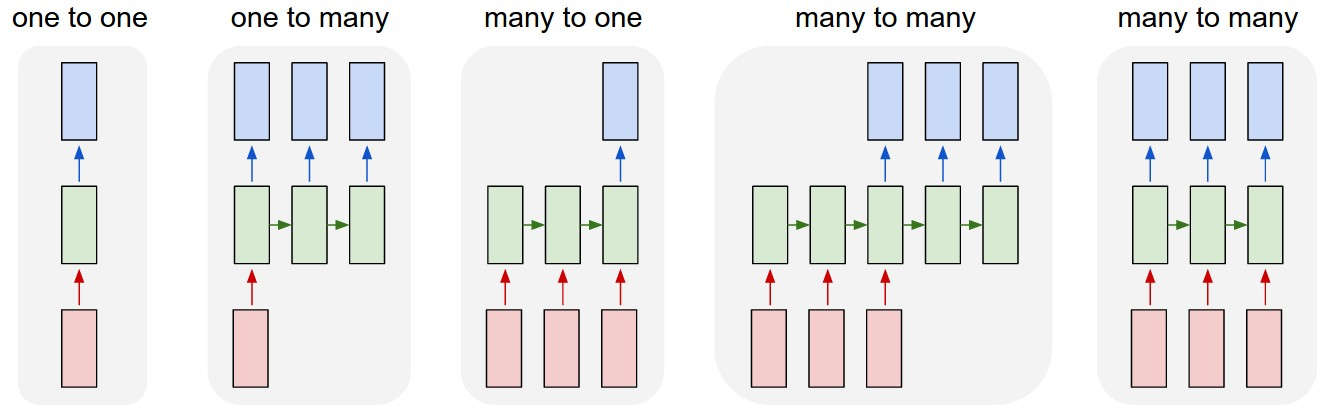

Image source: Andrej Karpathy

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### 1. Create a time series

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

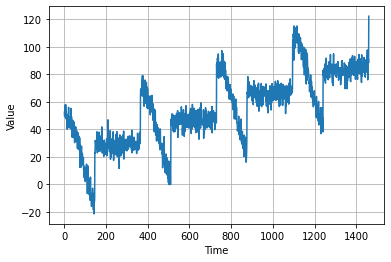

In [ ]:
plot_series(time, series)

In [ ]:
# Training/validation split
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### 2. Window Methods

In [ ]:
# Set the parameters
window_size = 20
batch_size = 32
shuffle_buffer_size =1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size +1, shift =1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

### 3. Modeling

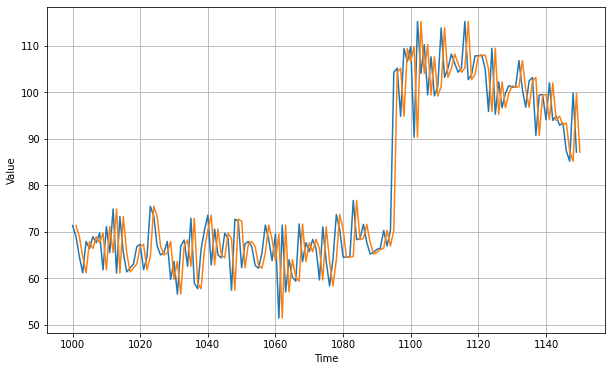

In [ ]:
# Naive Forecast - Baseline
naive_forecast = series[split_time -1: -1]

plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid, start = 0, end = 150)
plot_series(time_valid, naive_forecast, start =1, end =151)

In [ ]:
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

5.9379086


In [ ]:
# Find a learning rate with the lowest loss value. 

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100.0)])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer= optimizer, metrics=["mae"])

history = model.fit(dataset, epochs = 100, callbacks =[lr_schedule])

Epoch 1/100
31/31 [==============================] - 11s 12ms/step - loss: 21.9679 - mae: 22.4630
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 21.0787 - mae: 21.5699
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 19.9720 - mae: 20.4666
Epoch 4/100
31/31 [==============================] - 0s 11ms/step - loss: 20.5891 - mae: 21.0813
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 20.2777 - mae: 20.7735
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 19.6437 - mae: 20.1366
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 18.2940 - mae: 18.7848
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 17.2657 - mae: 17.7576
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 17.4906 - mae: 17.9840
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 16.8689 - mae: 17.3590
Epoch 11/100
31/31 [========

(1e-08, 0.0001, 0.0, 30.0)

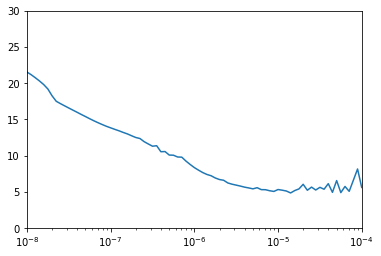

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-08, 1e-4, 0, 30])

In [ ]:
# Retrain the model with the selected learning rate. 

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=2)

Epoch 1/500
31/31 - 5s - loss: 774.9214 - mae: 21.4016
Epoch 2/500
31/31 - 0s - loss: 122.2953 - mae: 8.3610
Epoch 3/500
31/31 - 0s - loss: 118.6882 - mae: 8.5432
Epoch 4/500
31/31 - 0s - loss: 104.8326 - mae: 8.0300
Epoch 5/500
31/31 - 0s - loss: 112.8762 - mae: 8.1806
Epoch 6/500
31/31 - 0s - loss: 142.8421 - mae: 9.4693
Epoch 7/500
31/31 - 0s - loss: 71.8947 - mae: 6.6030
Epoch 8/500
31/31 - 0s - loss: 89.5555 - mae: 7.3591
Epoch 9/500
31/31 - 0s - loss: 64.3292 - mae: 6.1149
Epoch 10/500
31/31 - 0s - loss: 61.4876 - mae: 6.0040
Epoch 11/500
31/31 - 0s - loss: 87.5829 - mae: 7.3962
Epoch 12/500
31/31 - 0s - loss: 66.4908 - mae: 6.1767
Epoch 13/500
31/31 - 0s - loss: 73.0395 - mae: 6.6032
Epoch 14/500
31/31 - 0s - loss: 57.3956 - mae: 5.7362
Epoch 15/500
31/31 - 0s - loss: 59.2297 - mae: 5.8921
Epoch 16/500
31/31 - 0s - loss: 71.5151 - mae: 6.5991
Epoch 17/500
31/31 - 0s - loss: 84.5969 - mae: 7.2655
Epoch 18/500
31/31 - 0s - loss: 85.1089 - mae: 7.0897
Epoch 19/500
31/31 - 0s - loss

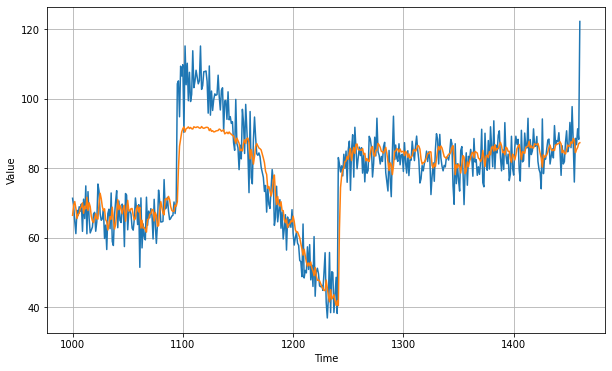

In [ ]:
forecast = []
results = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.524295

### 4. Visualization

<Figure size 432x288 with 0 Axes>

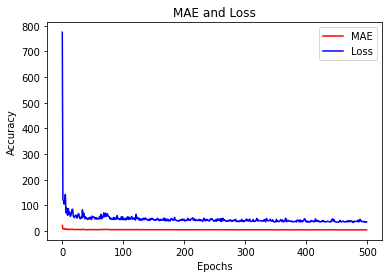

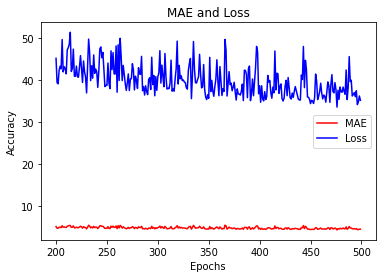

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

Data source: DeepLearning.AI TensorFlow Developer Professional Certificate Specialization on Coursera